In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

/Users/duqiming2004/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Toy Example (dim = 1)
* $X \sim \mathcal{N}(0,1)$ r.v that we could simulate
* $S:\mathbb{R} \to \mathbb{R}$ score function / blackbox i.e. we could simulate $S(X)$, but we don't know the form of $S$. here we take $S(X) = |X| $
* Goal : estimate $p = \mathbb{P}(S(X)>q) < 10^{-6}$ ( q = 5 rare event)

In [442]:
from numba import autojit
@autojit
def S(X):
    '''score function which is a black box'''
    return np.abs(X)

## The fixed-level method

In [965]:
# sequence of levels
num_lev = 5
#q = np.array([1.1,1.2,1.25,1.5,1.8])
q_test = 3
q = np.append(-np.Inf,np.sort(np.random.uniform(0.5,q_test,num_lev)))
q[num_lev] = q_test
print q

# real value of p
from scipy.stats import norm
p = (1-norm.cdf(q[num_lev]))*2
print "real value of p:" ,p

[       -inf  0.96316414  1.10396511  2.38498092  2.68978076  3.        ]
real value of p: 0.00269979606326


In [966]:
#tuning parameter 
sigma_1 = 1
var_tuning = float(sigma_1**2)/(1+sigma_1**2)
print "var_tuning: ",var_tuning
print "levels: ", q


###Estimation of p

N = 10000 # number of samples
X = np.zeros([num_lev,N])
X[0,:] = np.random.normal(0,1,N) 
p_hat = []
I = [[0] for k in range(num_lev-1)]
for k in range(num_lev-1):
    p_hat = np.append(p_hat,np.sum((S(X[k,]>q[k+1])))/float(N))
    print p_hat[k]
    for j in range(N):
        if S(X[k,j])>q[k+1]:
            I[k] = np.append(I[k],X[k,j])
    for j in range(N):
        if S(X[k,j])>q[k+1]:
            X[k+1,j] = X[k,j]
        else:
            l = np.random.choice(I[k])
            
            X[k+1,j] = X[k,l]
    
        X_iter = np.random.normal(X[k+1,j],np.sqrt(var_tuning),1)
        if S(X_iter)>q[k+1]:
            X[k+1,j] = X_iter
    
    


print "real value of p:" ,p
print "estimation of p: ", np.prod(p_hat)
print "relative variation: ",np.abs((p - np.prod(p_hat))/p)*np.sqrt(N)
print "N: ",N






var_tuning:  0.5
levels:  [       -inf  0.96316414  1.10396511  2.38498092  2.68978076  3.        ]
0.1658
0.1642
0.0411
0.0388
real value of p: 0.00269979606326
estimation of p:  4.34141424048e-05
relative variation:  98.3919473402
N:  10000


/Users/duqiming2004/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [768]:
# we will estimate p for different N 
p_list = []
variation = []
for N in np.array(np.linspace(500,10000,100),np.int):
    X = np.zeros([num_lev,N])
    X[0,:] = np.random.normal(0,1,N) 
    p_hat = []
    I = [[0] for k in range(num_lev-1)]
    for k in range(num_lev-1):
        p_hat = np.append(p_hat,np.sum((S(X[k,]>q[k+1])))/float(N))
        #print p_hat[k]
        for j in range(N):
            if S(X[k,j])>q[k+1]:
                I[k] = np.append(I[k],X[k,j])
        for j in range(N):
            if S(X[k,j])>q[k+1]:
                X[k+1,j] = X[k,j]
            else:
                l = np.random.choice(I[k])

                X[k+1,j] = X[k,l]

            X_iter = np.random.normal(X[k+1,j],np.sqrt(var_tuning),1)
            if S(X_iter)>q[k+1]:
                X[k+1,j] = X_iter



    variation = np.append(variation,np.abs((p - np.prod(p_hat))/p)*np.sqrt(N))
    p_list = np.append(p_list,np.prod(p_hat))
#     print "real value of p:" ,p
#     print "estimation of p: ", np.prod(p_hat)
#     print "relative variation: ",np.abs((p - np.prod(p_hat))/p)*np.sqrt(N)
#     print "N: ",N



/Users/duqiming2004/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


25897.9941088
89


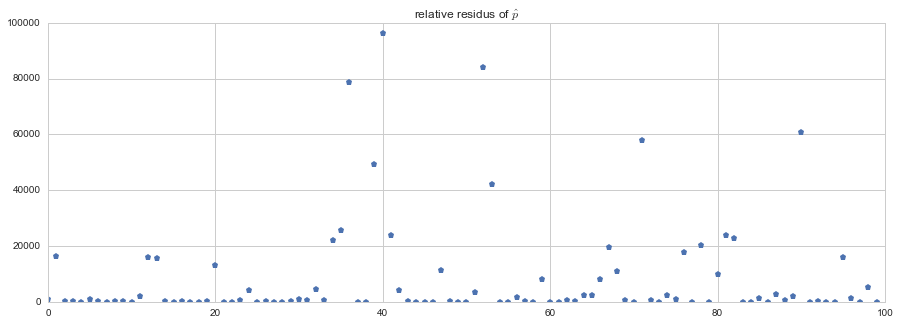

In [769]:
plt.figure(figsize=[15,5])
plt.plot(variation*(variation < 100000),"p")
print np.mean(variation)
print np.sum(variation < 50000)
plt.title("relative residus of $\hatp$")

var:  25897.9941088
'minimum' var(theoretic): 17189.283006
#{var<var(theoretic)}:  79
1-sigma :  0.682689492137


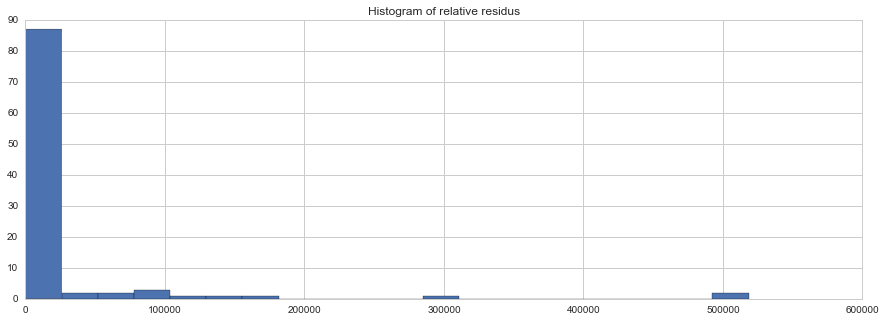

In [770]:
plt.figure(figsize = [15,5])
plt.hist(variation,bins = 20)
plt.title("Histogram of relative residus")
a = np.array([(1-norm.cdf(q[i]))*2 for i in range(num_lev)])[1:]
print 'var: ', np.mean(variation)
print "'minimum' var(theoretic):",np.sum((1-a)/a)
print "#{var<var(theoretic)}: ",np.sum(variation < np.sum((1-a)/a))
print "1-sigma : ",1- (1-norm.cdf(1))*2

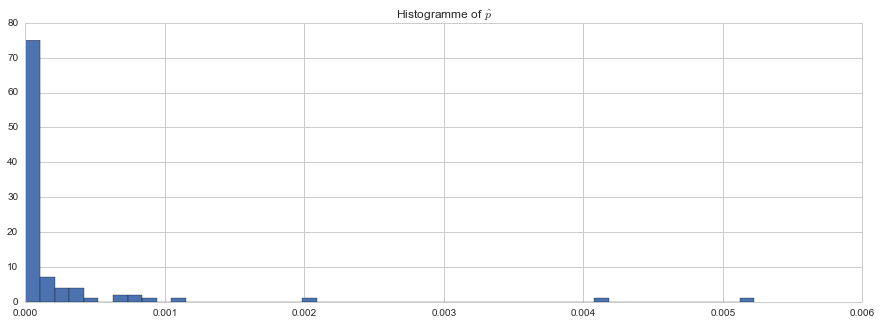

In [809]:
plt.figure(figsize = [15,5])
plt.hist(p_list,bins = 50)
plt.title("Histogramme of $\hatp$")


## Adaptive Multilevel Splitting    

In [973]:
p_0 = 0.5 # prescribed success rate
N = 5000 #size of sample
max_iter = 1000

# calculate the empirical quantile of X
@autojit
def L_empirical(X,percentage = p_0):
    
    return np.percentile(S(X),(1-percentage)*100,interpolation="lower")

###Estimation of p

X = np.random.normal(0,1,N)
L = np.array([-np.Inf,L_empirical(X)])
k = 1
while(L[k]<q_test):
    print k
    print L[k]
    X_new = []
    for i in range(N):
        if S(X[i])>L[k]:
            X_new = np.append(X_new, X[i])
        else:
            X_tilde = np.random.normal(0,1,1)
            thr = 1#add a threshold control the max_iter
            #while((S(X_tilde)<=L[k])*(thr< max_iter) == 1 ):
            while(S(X_tilde)<=L[k]):
                X_tilde = np.random.normal(0,1,1)
                thr += 1
            X_new = np.append(X_new, X_tilde)
                
            
    
    X = X_new
    L = np.append(L, L_empirical(X))
    k += 1
    
    N_L = np.sum((S(X)>=q_test))
    p_hat = N_L/float(N)*p_0**(k-1)
    print p_hat

print "k = ",k
    
N_L = np.sum((S(X)>=q_test))
p_hat = N_L/float(N)*p_0**(k-1)


print "real value of p:" ,p
print "estimation of p: ", p_hat
print "relative variation: ",np.abs((p - p_hat))/p*np.sqrt(N)
print "N: ",N



1
0.656889017874
0.0015
2
1.13846294266
0.0019
3
1.53381201353
0.002125
4
1.85352519806
0.002375
5
2.14172918699
0.0025
6
2.40481501984
0.0026
7
2.65083629089
0.0025703125
8
2.87883086552
0.0026109375
k =  9
real value of p: 0.00269979606326
estimation of p:  0.0026109375
relative variation:  2.32730514363
N:  5000
